In [86]:
import sys, os
import importlib.util
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import lambda2nu, nu2lambda, c

In [87]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

In [88]:
lumapiFile = r"C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
spec = importlib.util.spec_from_file_location("lumapi", lumapiFile)
lumapi = importlib.util.module_from_spec(spec)
spec.loader.exec_module(lumapi)
emeApi = lumapi.MODE(hide = False)

C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py:796: SyntaxWarning: invalid escape sequence '\s'
  message = re.sub('^(Error:)\s(prompt line)\s[0-9]+:', '', str(rvals[2])).strip()


In [89]:
um = 1e-6
nm = 1e-9

In [90]:
# Materials
material_Clad = "SiO2 (Glass) - Palik"
material_Si = "Si (Silicon) - Dispersive & Lossless"

# Add material Si
matname = material_Si
matReturn = emeApi.getmaterial(material_Si)
if (emeApi.findstring(matReturn, 'is not available') != -1):
    newmaterial = emeApi.addmaterial("Lorentz")
    emeApi.setmaterial(newmaterial, "name", matname)
    emeApi.setmaterial(matname, "Permittivity", 7.98737492)
    emeApi.setmaterial(matname, "Lorentz Linewidth", 1e8)
    emeApi.setmaterial(matname, "Lorentz Resonance", 3.93282466e+15)
    emeApi.setmaterial(matname, "Lorentz Permittivity", 3.68799143)
    emeApi.setmaterial(matname, "color", np.array([0.85, 0, 0, 1]))  # red

In [91]:
# Add material Clad
matname = material_Clad
matReturn = emeApi.getmaterial(material_Clad)
if (emeApi.findstring(matReturn, 'is not available') != -1):
    newmaterial = emeApi.addmaterial("Lorentz")
    emeApi.setmaterial(newmaterial, "name", matname)
    emeApi.setmaterial(matname, "Permittivity", 2.119881)
    emeApi.setmaterial(matname, "Lorentz Linewidth", 1e10)
    emeApi.setmaterial(matname, "Lorentz Resonance", 3.30923843e+15)
    emeApi.setmaterial(matname, "Lorentz Permittivity", 49.43721)
    emeApi.setmaterial(matname, "color", np.array([0.5, 0.5, 0.5, 1]))  # grey

In [92]:
# MMI x parameters
L = 57.35277921186466 *um

# MMI y parameters
W = 7 * um

# Taper parameters
W1 = 450 * nm
W2 = 1.26 * um
LT =  15.0* um
WY = W/6


# Waveguide parameters
wvg_width = 450 * nm
wvg_height = 220 * nm

# Waveguide length
wvg_length = 1.5 * um

# Bandwidth operation
cband = True
filename = "S_MMI_EME_2x2_%d_um" % (L / um)
filename_var = "S_MMI_VarFDTD_2x2_%d_um" % (L / um)


In [93]:
# C Band simulation: 1520 - 1575 nm
# L Band simulation: 1555 - 1635 nm
if cband:
    wvlngth_start = 1.520 * um
    wvlngth_stop = 1.575 * um
else:
    wvlngth_start = 1.555 * um
    wvlngth_stop = 1.635 * um

numFreqPnts = 50

In [94]:
emeApi.switchtolayout()

emeApi.deleteall()

emeApi.addstructuregroup()
dev_layer = 'GDS_LAYER_35:4'
emeApi.set('name',dev_layer)

In [95]:
emeApi.addrect()
emeApi.addtogroup(dev_layer)
emeApi.set("name", "box")
emeApi.set("x", 0)
emeApi.set("x span", L)
emeApi.set("y", 0)
emeApi.set("y span", W)
emeApi.set("z", wvg_height / 2)
emeApi.set("z span", wvg_height)
emeApi.set("material", material_Si)


In [96]:
# Tapers
for i in range(4):
    emeApi.addobject("linear_taper")
    emeApi.set("name", f"taper port {str(i + 1)}")
    emeApi.set("thickness", wvg_height)
    emeApi.set("angle_side", 90)
    emeApi.set("width_l", W2)
    emeApi.set("width_r", W1)
    emeApi.set("len", LT)
    emeApi.set("material", material_Si)
    emeApi.set("x", emeApi.getnamed(f"{dev_layer}::box", "x max") + LT / 2)
    emeApi.set("y", WY)
    emeApi.set("z", wvg_height / 2)

# 01
emeApi.select(f"{dev_layer}::taper port 1")
emeApi.set("width_l", W1)
emeApi.set("width_r", W2)
emeApi.set("y", WY)
emeApi.set("x", -emeApi.getnamed(f"{dev_layer}::box", "x max") - LT / 2)

# 02
emeApi.select(f"{dev_layer}::taper port 2")
emeApi.set("width_l", W1)
emeApi.set("width_r", W2)
emeApi.set("x", -emeApi.getnamed(f"{dev_layer}::box", "x max") - LT / 2)
emeApi.set("y", -WY)

# 03
emeApi.select(f"{dev_layer}::taper port 3")
emeApi.set("y", -WY)


In [97]:
# Waveguides
for i in range(4):
    emeApi.addrect()
    emeApi.addtogroup(dev_layer)
    emeApi.set("name", f"port {str(i + 1)}")
    emeApi.set("x", (L + wvg_length + 2 * LT) / 2)
    emeApi.set("x span", wvg_length)
    emeApi.set("y", WY)
    emeApi.set("y span", wvg_width)
    emeApi.set("z", wvg_height / 2)
    emeApi.set("z span", wvg_height)
    emeApi.set("material", material_Si)

# 01
emeApi.select(f"{dev_layer}::port 1")
emeApi.set("x", -(L + wvg_length + 2 * LT) / 2)

# 02
emeApi.select(f"{dev_layer}::port 2")
emeApi.set("x", -(L + wvg_length + 2 * LT) / 2)
emeApi.set("y", -WY)

# 03
emeApi.select(f"{dev_layer}::port 3")
emeApi.set("y", -WY)


In [98]:
# Add solver
emeApi.select("EME")
emeApi.delete()

emeApi.addeme()

bound_x_offset = 0.5 * um
bound_y_offset = 2 * um
bound_z_offset = 0.5 * um

port_y_span = 2 * um
port_z_span = 2 * um

## Dimensions
emeApi.set("x", 0)
emeApi.set("x min", bound_x_offset + emeApi.getnamed(f"{dev_layer}::port 1", "x min"))

emeApi.set("y", 0)
emeApi.set("y span", W + 2 * bound_y_offset)
emeApi.set("z", wvg_height / 2)
emeApi.set("z span", port_z_span + 2 * bound_z_offset)

## Background material
emeApi.set("background material", material_Clad)


In [99]:
cell_wgd = 1
cell_taper = 16
cell_box = 1

span_wgd = wvg_length - bound_x_offset
span_taper = LT
span_box = L

method_wgd = 0  # 0 = none, 1 = CVCS
method_taper = 1
method_box = 0

modes_wgd = 4
modes_taper = 10
modes_box = 32

## Set cell properties
emeApi.set("number of cell groups", 5)
emeApi.set("group spans", np.block([[span_wgd], [span_taper], [span_box], [span_taper], [span_wgd]]))
emeApi.set("cells", np.block([[cell_wgd], [cell_taper], [cell_box], [cell_taper], [cell_wgd]]))
emeApi.set("subcell method", np.block([[method_wgd], [method_taper], [method_box], [method_taper], [method_wgd]]))
emeApi.set("allow custom eigensolver settings", True)
emeApi.set("modes", np.block([[modes_wgd], [modes_taper], [modes_box], [modes_taper], [modes_wgd]]))
emeApi.set("display cells", 1)

## Number of mesh cells without override regions
emeApi.set("mesh cells y", 200)
emeApi.set("mesh cells z", 200)

## Boundary Conditions
emeApi.set("y min bc", "PML")
emeApi.set("y max bc", "PML")
emeApi.set("z min bc", "PML")
emeApi.set("z max bc", "PML")


In [100]:
## Configura as portas
emeApi.select("EME::Ports::port_1")
emeApi.set("use full simulation span", 0)
emeApi.set("y", WY)
emeApi.set("y span", port_y_span)
emeApi.set("z", 0)
emeApi.set("z span", port_z_span)
emeApi.set("mode selection", "fundamental TE mode")

emeApi.select("EME::Ports::port_2")
emeApi.set("use full simulation span", 0)
emeApi.set("port location", "left")
emeApi.set("y", -WY)
emeApi.set("y span", port_y_span)
emeApi.set("z", 0)
emeApi.set("z span", port_z_span)
emeApi.set("mode selection", "fundamental TE mode")

emeApi.addemeport()
emeApi.set("use full simulation span", 0)
emeApi.set("port location", "right")
emeApi.set("y", -WY)
emeApi.set("y span", port_y_span)
emeApi.set("z", 0)
emeApi.set("z span", port_z_span)
emeApi.set("mode selection", "fundamental TE mode")

emeApi.addemeport()
emeApi.set("use full simulation span", 0)
emeApi.set("port location", "right")
emeApi.set("y", WY)
emeApi.set("y span", port_y_span)
emeApi.set("z", 0)
emeApi.set("z span", port_z_span)
emeApi.set("mode selection", "fundamental TE mode")

In [101]:
## Add monitor
emeApi.addemeprofile()
emeApi.set("name", "profile")
emeApi.set("monitor type", 3)  # 2D z-normal
emeApi.set("x", 0)
emeApi.set("x span", emeApi.getnamed("EME", "x span"))
emeApi.set("y", 0)
emeApi.set("y span", W + 2 * bound_y_offset)
emeApi.set("z", wvg_height / 2)




In [102]:
mesh_multiplier=3

emeApi.select('mesh')
emeApi.delete()

emeApi.addmesh()
emeApi.set('set mesh multiplier', True)
## Dimensions
emeApi.set("x", 0)
emeApi.set("x span",L+2*LT+2*wvg_length-1*um)
emeApi.set("y", 0)
emeApi.set("y span", W + 2 * bound_y_offset)
emeApi.set("z", wvg_height / 2)
emeApi.set("z span", port_z_span + 2 * bound_z_offset)
#emeApi.set("set maximum mesh step",0)
emeApi.set('x mesh multiplier', mesh_multiplier)
emeApi.set('y mesh multiplier', mesh_multiplier)
emeApi.set('z mesh multiplier', mesh_multiplier)

In [103]:
# Save the setup
emeApi.save(filename)

# Field

In [106]:
emeApi.run()

In [105]:
emeApi.emepropagate()

C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py:796: SyntaxWarning: invalid escape sequence '\s'
  message = re.sub('^(Error:)\s(prompt line)\s[0-9]+:', '', str(rvals[2])).strip()


LumApiError: 'emepropagate cannot be used while in layout mode.'

In [ ]:
# Field profile
E = emeApi.getresult("profile", "field profile")

x = E['x']
x = x[:,0]/um

y = E['y']
y = y[:,0]/um

z = E['z']
E = E['E']

Ex = E[:, :, 0, :, 0]
Ey = E[:, :, 0, :, 1]
Ez = E[:, :, 0, :, 2]

Emag = np.sqrt(np.abs(Ex)**2 + np.abs(Ey)**2 + np.abs(Ez)**2)

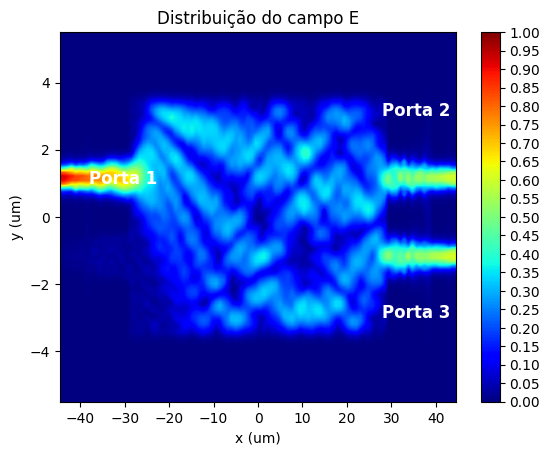

In [ ]:
plt.figure()
mycmap = plt.get_cmap('jet')

v = np.linspace(0, 1, 999, endpoint=True)
cbar = np.linspace(0,1,21)

contour = plt.contourf(x, y, np.transpose(Emag[:,:,0]), v, cmap=mycmap)
plt.colorbar(ticks=cbar)

plt.title("Distribuição do campo E", fontsize=12)
plt.ylabel("y (um)", fontsize=10)
plt.xlabel("x (um)", fontsize=10)



plt.text(-38, 1, 'Porta 1', fontsize=12, fontweight='bold', color='w')
plt.text(28, -3, 'Porta 3', fontsize=12, fontweight='bold', color='w')
plt.text(28, 3, 'Porta 2', fontsize=12, fontweight='bold', color='w')

plt.show()


# Análise propagation sweep

In [ ]:
emeApi.setemeanalysis('propagation sweep', 1)
emeApi.setemeanalysis('parameter', 'group span 3')
emeApi.setemeanalysis('start', 0.9*span_box)
emeApi.setemeanalysis('stop', 1.1*span_box)
emeApi.setemeanalysis('number of points', numFreqPnts)

In [ ]:
emeApi.emesweep('propagation sweep')


In [ ]:
S = emeApi.getemesweep('S')
group_span = S['group_span_3']

T1 = np.abs(S['s11'])**2
T2 = np.abs(S['s21'])**2
T3 = np.abs(S['s31'])**2
T4 = np.abs(S['s41'])**2

T1_dB = 10*np.log10(T1)
T2_dB = 10*np.log10(T2)
T3_dB = 10*np.log10(T3)
T4_dB = 10*np.log10(T4)

Corresponding value of group_span: [55.59708189]


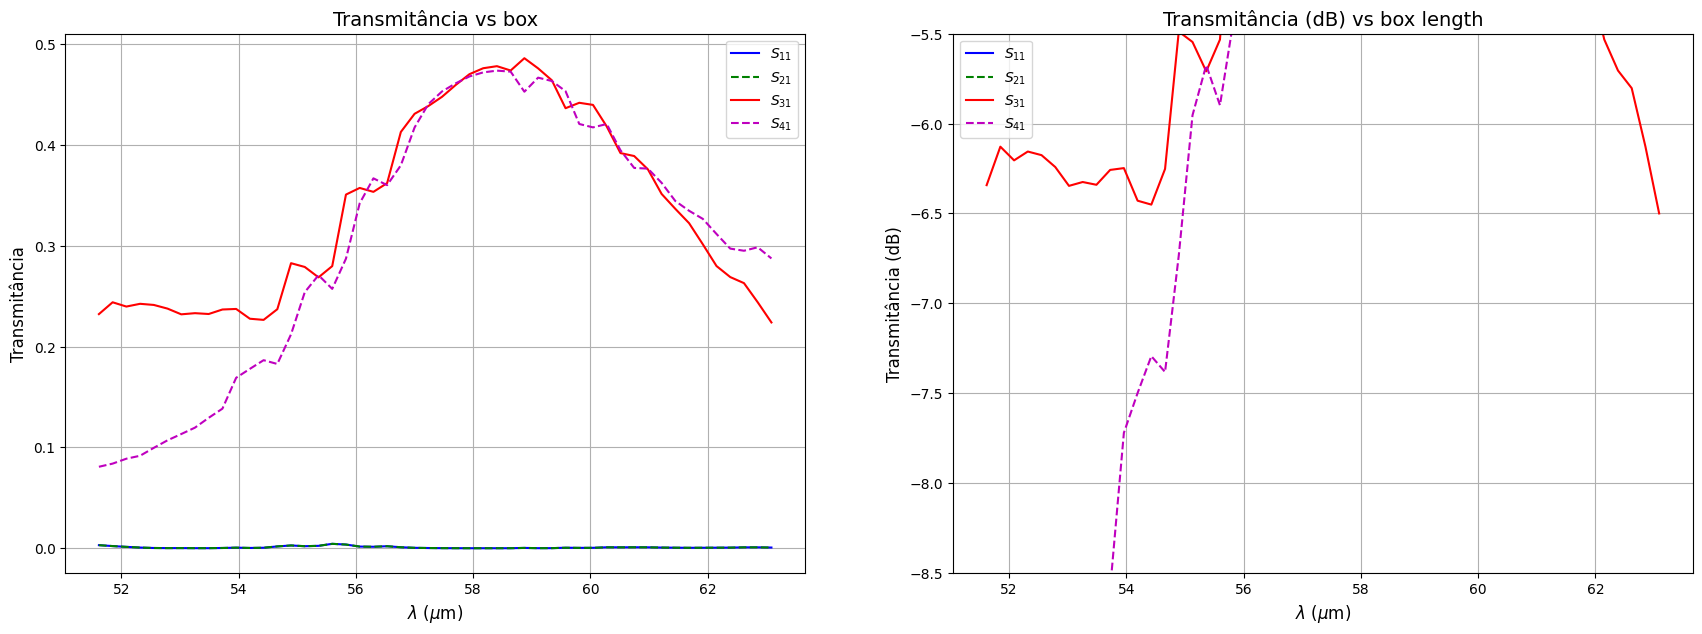

In [ ]:

fig, axs = plt.subplots(1, 2, figsize = (21, 7))

axs[0].plot(group_span/um, T1, 'b', lw = 1.5, label = '$S_{11}$')
axs[0].plot(group_span/um, T2, 'g--', lw = 1.5, label = '$S_{21}$')
axs[0].plot(group_span/um, T3, 'r', lw = 1.5, label = '$S_{31}$')
axs[0].plot(group_span/um, T4, 'm--', lw = 1.5, label = '$S_{41}$')
axs[0].set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 12)
axs[0].set_ylabel('Transmitância', fontsize = 12)
axs[0].set_title("Transmitância vs box", fontsize = 14)
#axs[0].set_xlim([38.65, 47.25])
#axs[0].set_ylim([0, 0.3])
axs[0].grid()
axs[0].legend()

# Find the index of the maximum value in T2
max_index = np.argmax(T2)

# Use that index to get the corresponding value in group_span
corresponding_group_span = group_span[max_index]

print("Corresponding value of group_span:", corresponding_group_span/um)

axs[1].plot(group_span/um, T1_dB, 'b', lw = 1.5, label = '$S_{11}$')
axs[1].plot(group_span/um, T2_dB, 'g--', lw = 1.5, label = '$S_{21}$')
axs[1].plot(group_span/um, T3_dB, 'r', lw = 1.5, label = '$S_{31}$')
axs[1].plot(group_span/um, T4_dB, 'm--', lw = 1.5, label = '$S_{41}$')
axs[1].set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 12)
axs[1].set_ylabel('Transmitância (dB)', fontsize = 12)
axs[1].set_title("Transmitância (dB) vs box length", fontsize = 14)
#axs[1].set_xlim([38.65, 47.25])
axs[1].set_ylim([-8.5, -5.5])
axs[1].grid()
axs[1].legend()




# Análise - wavelength sweep

In [ ]:
emeApi.setemeanalysis("group spans", np.block([[span_wgd], [span_taper], [corresponding_group_span], [span_taper], [span_wgd]]))
emeApi.getemeanalysis("group spans")


emeApi.setemeanalysis('wavelength sweep', 1)
emeApi.setemeanalysis('start wavelength', wvlngth_start)
emeApi.setemeanalysis('stop wavelength', wvlngth_stop)
emeApi.setemeanalysis('number of wavelength points', numFreqPnts)
emeApi.setemeanalysis('calculate group delays', 1)

emeApi.emesweep('wavelength sweep')
S = emeApi.getemesweep('S_wavelength_sweep')
Lambda = S['wavelength']

T1 = np.abs(S['s11'])**2
T2 = np.abs(S['s21'])**2
T3 = np.abs(S['s31'])**2
T4 = np.abs(S['s41'])**2

T1_dB = 10*np.log10(T1)
T2_dB = 10*np.log10(T2)
T3_dB = 10*np.log10(T3)
T4_dB = 10*np.log10(T4)

<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:21: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:21: SyntaxWarning: invalid escape sequence '\l'
C:\Users\juame\AppData\Local\Temp\ipykernel_26192\1975452156.py:9: SyntaxWarning: invalid escape sequence '\l'
  axs[0].set_title("Transmitância vs $\lambda$ ($\mu$m)", fontsize = 14, fontstyle = 'italic')
C:\Users\juame\AppData\Local\Temp\ipykernel_26192\1975452156.py:21: SyntaxWarning: invalid escape sequence '\l'
  axs[1].set_title("Transmitância (dB) vs $\lambda$ ($\mu$m)", fontsize = 14, fontstyle = 'italic')


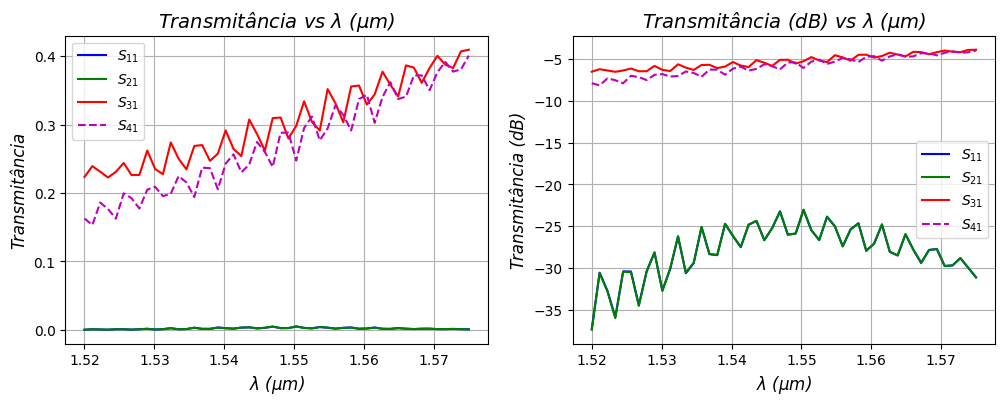

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

axs[0].plot(Lambda/um, T1, 'b', lw = 1.5, label = '$S_{11}$')
axs[0].plot(Lambda/um, T2, 'g', lw = 1.5, label = '$S_{21}$')
axs[0].plot(Lambda/um, T3, 'r', lw = 1.5, label = '$S_{31}$')
axs[0].plot(Lambda/um, T4, 'm--', lw = 1.5, label = '$S_{41}$')
axs[0].set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 12, fontstyle = 'italic')
axs[0].set_ylabel('Transmitância', fontsize = 12,fontstyle = 'italic')
axs[0].set_title("Transmitância vs $\lambda$ ($\mu$m)", fontsize = 14, fontstyle = 'italic')
#axs[0].set_xlim([1.53, 1.565])
#axs[0].set_ylim([0, 0.5])
axs[0].grid()
axs[0].legend()

axs[1].plot(Lambda/um, T1_dB, 'b', lw = 1.5, label = '$S_{11}$')
axs[1].plot(Lambda/um, T2_dB, 'g', lw = 1.5, label = '$S_{21}$')
axs[1].plot(Lambda/um, T3_dB, 'r', lw = 1.5, label = '$S_{31}$')
axs[1].plot(Lambda/um, T4_dB, 'm--', lw = 1.5, label = '$S_{41}$')
axs[1].set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 12, fontstyle = 'italic')
axs[1].set_ylabel('Transmitância (dB)', fontsize = 12, fontstyle = 'italic')
axs[1].set_title("Transmitância (dB) vs $\lambda$ ($\mu$m)", fontsize = 14, fontstyle = 'italic')
#axs[1].set_xlim([1.53, 1.565])
#axs[1].set_ylim([-10, 1])
axs[1].grid()
axs[1].legend()


<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
C:\Users\juame\AppData\Local\Temp\ipykernel_26192\1710370469.py:8: SyntaxWarning: invalid escape sequence '\l'
  axs[0].set_title("Imbalance (dB) vs $\lambda$ ($\mu$m)", fontsize = 14)
C:\Users\juame\AppData\Local\Temp\ipykernel_26192\1710370469.py:17: SyntaxWarning: invalid escape sequence '\l'
  axs[1].set_title("Insertion loss (dB) vs $\lambda$ ($\mu$m)", fontsize = 14)


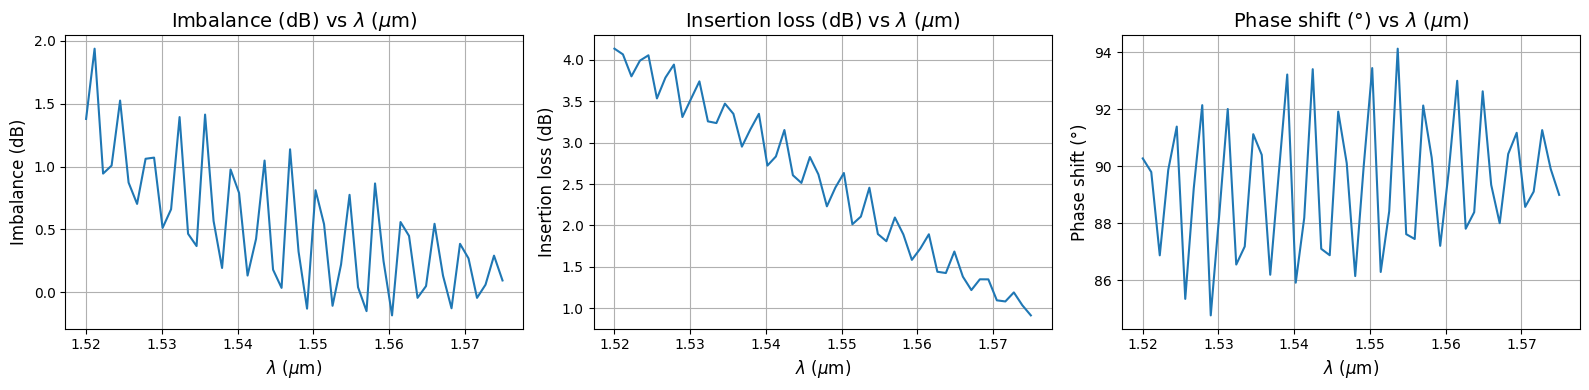

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (16, 4))

# Imbalance
Ib = T3_dB - T4_dB
axs[0].plot(Lambda/um, Ib, lw = 1.5)
axs[0].set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 12)
axs[0].set_ylabel("Imbalance (dB)", fontsize = 12)
axs[0].set_title("Imbalance (dB) vs $\lambda$ ($\mu$m)", fontsize = 14)
#axs[0].set_xlim([1.53, 1.565])
axs[0].grid()

# Insertion loss
Il = -10*np.log10(T3 + T4)
axs[1].plot(Lambda/um, Il, lw = 1.5)
axs[1].set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 12)
axs[1].set_ylabel("Insertion loss (dB)", fontsize = 12)
axs[1].set_title("Insertion loss (dB) vs $\lambda$ ($\mu$m)", fontsize = 14)
#axs[1].set_xlim([1.53, 1.565])
axs[1].grid()

# Phase shift

phi1 = np.angle(S['s31'])
phi2 = np.angle(S['s41'])
phase = (phi1 - phi2) * (180/np.pi)

for p in range(len(phase)):
    if abs(phase[p]) > 200:
        phase[p] = phase[p] + 360

axs[2].plot(Lambda/um, phase, lw = 1.5)
axs[2].set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 12)
axs[2].set_ylabel("Phase shift (°)", fontsize = 12)
axs[2].set_title(r"Phase shift (°) vs $\lambda$ ($\mu$m)", fontsize = 14)
#axs[2].set_xlim([1.53, 1.565])
axs[2].grid()

plt.tight_layout()

In [ ]:
emeApi.switchtolayout()
emeApi.select('EME')
emeApi.delete()

In [ ]:
# MMI x parameters
L = 59 *um

In [ ]:
# Add solver
emeApi.select("varFDTD")
emeApi.delete()
emeApi.addvarfdtd()


bound_x_offset = 0.5 * um
bound_y_offset = 2 * um
bound_z_offset = 0.5 * um

port_y_span = 2 * um
port_z_span = 2 * um

## Dimensions
emeApi.set("x", 0)
emeApi.set("x span",L+2*LT+2*wvg_length-1*um)

emeApi.set("y", 0)
emeApi.set("y span", W + 2 * bound_y_offset)

emeApi.set("z", wvg_height / 2)
emeApi.set("z span", port_z_span + 2 * bound_z_offset)
emeApi.set('z min bc','Symmetric')

emeApi.set("x0", 0)

## Background material
emeApi.set("background material", material_Clad)

emeApi.set("global monitor frequency points", 100);
emeApi.set("mesh accuracy", 10);



In [ ]:

# Inicializando test_points como uma matriz numpy
test_points = np.zeros((2, 4))

# Definindo os valores de matrixx e ymatrix
xmatrix = L/2
ymatrix = WY

# Preenchendo dinamicamente
for i in range(4):
    test_points[0, i] = xmatrix if i % 2 == 1 else -xmatrix
    test_points[1, i] = ymatrix if i < 2 else -ymatrix
    
    

emeApi.set("test points",test_points);

In [ ]:
emeApi.select('source')
emeApi.delete()

emeApi.addmodesource();
emeApi.set("injection axis", "x");
#set("direction","Backward");
emeApi.set("x", bound_x_offset + emeApi.getnamed(f"{dev_layer}::port 1", "x min")+0.5*um)
emeApi.set("y", WY);
emeApi.set("y span", 1*um);
emeApi.set("wavelength start", 1500e-9);
emeApi.set("wavelength stop", 1600e-9);

In [ ]:
emeApi.switchtolayout()

mesh_multiplier=3

emeApi.select('mesh')
emeApi.delete()

emeApi.addmesh()
#emeApi.set('set mesh multiplier', True)
## Dimensions
emeApi.set("x", 0)
emeApi.set("x span",L+2*LT+2*wvg_length-1*um)
emeApi.set("y", 0)
emeApi.set("y span", W + 2 * bound_y_offset)
emeApi.set("z", wvg_height / 2)
emeApi.set("z span", port_z_span + 2 * bound_z_offset)
emeApi.set("set maximum mesh step",0)
emeApi.set('equivalent x index', mesh_multiplier)
emeApi.set('equivalent y index', mesh_multiplier)
emeApi.set('equivalent z index', mesh_multiplier)

In [ ]:
# emeApi.add monitors

emeApi.select('index')
emeApi.delete()
emeApi.addindex()
emeApi.set("name", "index")
emeApi.set('monitor type',"2D Z-normal")
emeApi.set("x", 0)
emeApi.set("x span",L+2*LT+2*wvg_length-1*um)
emeApi.set("y", 0)
emeApi.set("y span", W + 2 * bound_y_offset)

emeApi.select('monitor')
emeApi.delete()
emeApi.addprofile()
emeApi.set('monitor type',"2D Z-normal")
emeApi.set("x", 0)
emeApi.set("x span",L+2*LT+2*wvg_length-1*um)
emeApi.set("y", 0)
emeApi.set("y span", W + 2 * bound_y_offset)

emeApi.select('in_1')
emeApi.delete()
emeApi.addpower()
emeApi.set("name", "in_1")
emeApi.set("monitor type", 5)
emeApi.set("x",bound_x_offset + emeApi.getnamed(f"{dev_layer}::port 1", "x min")+0.5*um)
emeApi.set("y", WY)
emeApi.set("y span",wvg_width+1*um )
emeApi.set('z',0)
emeApi.set('z span', port_z_span + 2 * bound_z_offset)

emeApi.select('in_2')
emeApi.delete()
emeApi.addpower()
emeApi.set("name", "in_2")
emeApi.set("monitor type", 5)
emeApi.set("x",bound_x_offset + emeApi.getnamed(f"{dev_layer}::port 1", "x min")+0.5*um)
emeApi.set("y", -WY)
emeApi.set("y span",wvg_width+1*um )
emeApi.set('z',0)
emeApi.set('z span',port_z_span + 2 * bound_z_offset)

emeApi.select('out_1')
emeApi.delete()
emeApi.addpower()
emeApi.set("name", "out_1")
emeApi.set("monitor type", 5)
emeApi.set("x",-(bound_x_offset + emeApi.getnamed(f"{dev_layer}::port 1", "x min")+0.5*um))
emeApi.set("y", WY)
emeApi.set("y span",wvg_width+1*um )
emeApi.set('z',0)
emeApi.set('z span',port_z_span + 2 * bound_z_offset)

emeApi.select('out_2')
emeApi.delete()
emeApi.addpower()
emeApi.set("name", "out_2")
emeApi.set("monitor type", 5)
emeApi.set("x",-(bound_x_offset + emeApi.getnamed(f"{dev_layer}::port 1", "x min")+0.5*um))
emeApi.set("y", -WY)
emeApi.set("y span",wvg_width+1*um)
emeApi.set('z',0)
emeApi.set('z span',port_z_span + 2 * bound_z_offset)


In [ ]:
# Save the setup
#emeApi.save(filename_var)

In [ ]:
emeApi.run()

In [ ]:

E_data = emeApi.getresult('monitor','E')
print('E_data')


E_data


In [ ]:
x = E_data['x']
x = x[:,0]/um

y = E_data['y']
y = y[:,0]/um

z = E_data['z']
E_data = E_data['E']

Ex = E_data[:, :, 0, :, 0]
Ey = E_data[:, :, 0, :, 1]
Ez = E_data[:, :, 0, :, 2]

Emag = np.sqrt(np.abs(Ex)**2 + np.abs(Ey)**2 + np.abs(Ez)**2)

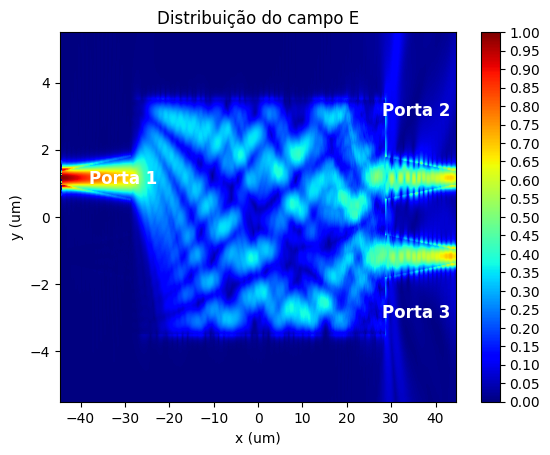

In [ ]:
plt.figure()
mycmap = plt.get_cmap('jet')

v = np.linspace(0, 1, 999, endpoint=True)
cbar = np.linspace(0,1,21)

contour = plt.contourf(x, y, np.transpose(Emag[:,:,0]), v, cmap=mycmap)
plt.colorbar(ticks=cbar)

plt.title("Distribuição do campo E", fontsize=12)
plt.ylabel("y (um)", fontsize=10)
plt.xlabel("x (um)", fontsize=10)



plt.text(-38, 1, 'Porta 1', fontsize=12, fontweight='bold', color='w')
plt.text(28, -3, 'Porta 3', fontsize=12, fontweight='bold', color='w')
plt.text(28, 3, 'Porta 2', fontsize=12, fontweight='bold', color='w')

plt.show()

In [ ]:
xlog = np.log10(E_data['x'])
xlog = xlog[:,0]/um

ylog = np.log10(E_data['y'])
ylog = ylog[:,0]/um

zlog = E_data['z']
E_data = E_data['E']

Exlog = E_data[:, :, 0, :, 0]
Eylog = E_data[:, :, 0, :, 1]
Ezlog = E_data[:, :, 0, :, 2]

Emag = np.sqrt(np.abs(Exlog)**2 + np.abs(Eylog)**2 + np.abs(Ez)**2)

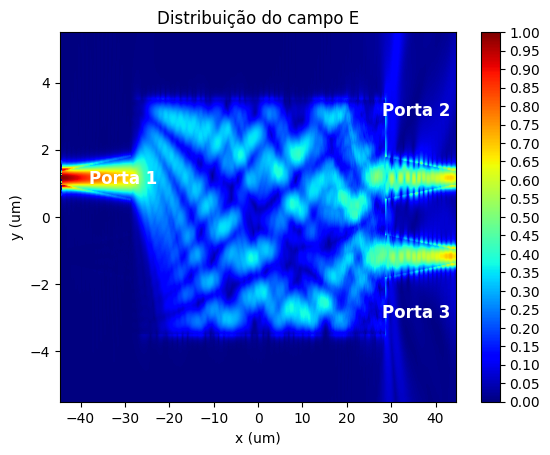

In [ ]:
plt.figure()
mycmap = plt.get_cmap('jet')

v = np.linspace(0, 1, 999, endpoint=True)
cbar = np.linspace(0,1,21)

contour = plt.contourf(xlog, ylog, np.transpose(Emag[:,:,0]), v, cmap=mycmap)
plt.colorbar(ticks=cbar)

plt.title("Distribuição do campo E", fontsize=12)
plt.ylabel("y (um)", fontsize=10)
plt.xlabel("x (um)", fontsize=10)



plt.text(-38, 1, 'Porta 1', fontsize=12, fontweight='bold', color='w')
plt.text(28, -3, 'Porta 3', fontsize=12, fontweight='bold', color='w')
plt.text(28, 3, 'Porta 2', fontsize=12, fontweight='bold', color='w')

plt.show()